## Flow Matching for Trajectories
* Adapted from https://github.com/dome272/Flow-Matching/blob/main/flow-matching.ipynb


## Imports

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import math
from torch import nn
import torch
import os
import statistics as stat

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"CUDA version: {torch.version.cuda}")
torch.cuda.set_device('cuda:0')

Device: cuda:0
CUDA version: 12.4


## Frame and Trajectory generation
* A potential issue with trajectory generation is the incredible length needed to go from one end of the area to the other. Since the next point is in no way optimized to reaching a destination, the trajectories are quite non-smooth and do not "utilize" their length in a beneficial manner.
* That being said, this might not matter if the model is sufficiently able.
* A discussion about wether or not the trajectories should be anchored to some valid start/goal locations, and then be free to move is in order.

In [95]:
# Frame dimensions
x_min, x_max = -100, 100
y_min, y_max = -100, 100

# Define pillar dimensions
pillar_width = 0.6 * (x_max - x_min)
pillar_height = 0.25 * (y_max - y_min)

# Calculate pillar bounds
pillar_x_min = x_min
pillar_x_max = x_min + int(pillar_width)
pillar_y_min = y_min + (y_max - y_min) // 2 - int(pillar_height / 2)
pillar_y_max = pillar_y_min + int(pillar_height)

# Function to check if a point is inside the blocked area
def is_inside_pillar(x, y):
    return (pillar_x_min <= x < pillar_x_max) and (pillar_y_min <= y < pillar_y_max)

def generate_trajectories(num_trajectories, num_steps):
    trajectories = []
    while len(trajectories) != num_trajectories:
        # Random starting point within the frame
        x_start = np.random.uniform(x_min, x_max)
        y_start = np.random.uniform(y_min, y_max)
        
        # Generate trajectory points
        trajectory = [(x_start, y_start)]
        for _ in range(num_steps - 1):
            # Generate random movement (e.g., random walk)
            x_new = trajectory[-1][0] + np.random.uniform(-1, 1)
            y_new = trajectory[-1][1] + np.random.uniform(-1, 1)
            trajectory.append((x_new, y_new))
        # trajectories.append(trajectory)
        # # Check if any point of the trajectory is inside the pillar
        if not any(is_inside_pillar(x, y) for x, y in trajectory):
            trajectories.append(trajectory)
    trajectories = np.array(trajectories)
    return trajectories

In [96]:
# Parameters
num_trajectories = 1000
num_steps = 1000

# Generate valid trajectories
valid_trajectories = generate_trajectories(num_trajectories, num_steps)

def show_trajectories(valid_trajectories):
    plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max])

    plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='red', alpha=0.5) # "Pillar"

    # Plot valid trajectories
    for count, trajectory in enumerate(valid_trajectories):
        plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label=f"Trajectory {count}")

    plt.title("Valid Trajectories with 'Blocked Area'")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    # plt.legend()
    plt.show()

## Show Trajectories

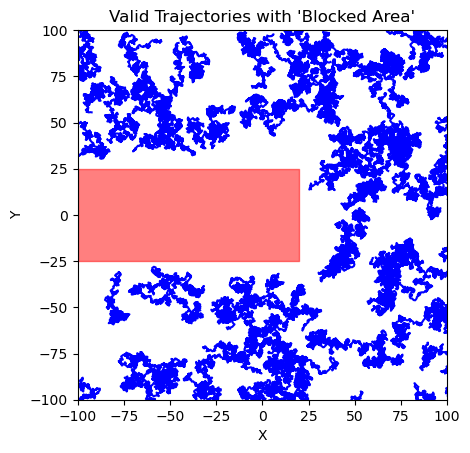

In [97]:
show_trajectories(valid_trajectories)

## Model Architecture

In [98]:

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb_scale = math.log(max_positions) / (half_dim - 1)
        frequencies = torch.arange(half_dim, device=t.device).float().mul(-emb_scale).exp()
        emb = t[..., None] * frequencies
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)

        if self.channels_t % 2 == 1:
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x) # Projects the 2D data to a larger number (512)
        t = self.gen_t_embedding(t) # Includes timestep t with cosine/sine embeddings
        t = self.t_projection(t) # Linear layer on top of previous steps^^
        x_extended = x.unsqueeze(2).expand(-1, -1, t.size(2), -1)
        x = x_extended + t  # Timestep embedding to the input.
        x = self.blocks(x) # Linear layers and ReLu activations
        x = self.out_projection(x)
        return x

In [99]:
model = MLP(layers=5, channels=512).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
model_path = "model.pt"

## Load pretrained model

In [100]:
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.eval()

## Training

In [101]:
import tqdm
data = torch.tensor(valid_trajectories, dtype=torch.float32, device=device)
print(f"Device: {data.get_device()}")
num_steps = data.shape[1]
num_trajectories = data.shape[0] 
training_steps = 1000000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    batch_indices = torch.randint(data.size(0), (batch_size,), device=device)
    x1 = data[batch_indices]
    x0 = torch.randn_like(x1)
    target = x1 - x0 # The target the NN should try to predict. 
    target = target.unsqueeze(2).expand(-1, num_steps, -1, -1)
    t = torch.rand(x1.size(0), device=device)
    t = t[:, None, None] 
    t = t.expand(t.size(0), num_steps, 2)
    xt = (1 - t) * x0 + t * x1
    pred = model(xt, t)
    loss = ((target - pred) ** 2).mean() # L2 loss
    loss.backward()
    optim.step()
    optim.zero_grad()   
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

# torch.save(model.state_dict(), model_path)


Device: 0


100%|██████████| 10000/10000 [06:11<00:00, 26.94it/s, loss=143]  


## Losses
* Plotting
* Saving

Closing file


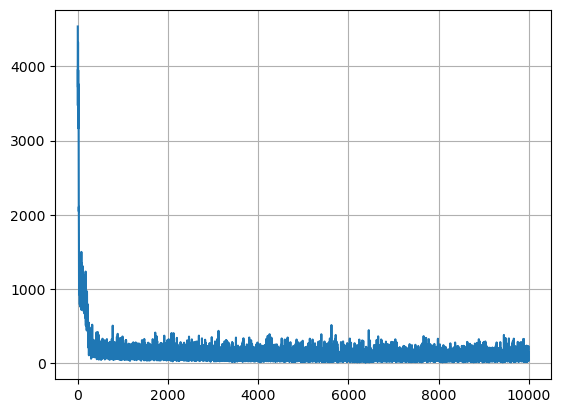

In [111]:
plt.plot(losses)
plt.grid()
final_loss = losses[-1]
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

loss_file = "Loss_data.csv"
access_mode = "w+" # Both reading and writing, most importantly creates a file if one does not already exist

try:
    file = open(loss_file, access_mode)
    file.write(f"Final loss value: {final_loss}\n")
    file.write(f"Average loss value: {avg_loss}\n")
    file.write(f"Median loss value: {med_loss}\n")
except IOError as e:
    print(f"An error occured: {e}")
finally:
    print(f"Closing file")
    file.close()
 

In [ ]:
print(f"Last loss value: {losses[-1]}")
print(f"Average loss value: {sum(losses)/len(losses)}")
print(f"Median loss value: {stat.median(losses)}")

## Sampling
* Problem with sampling as of 29.01 is that there is noe apparent connection between the points generated, causing eventual trajectories to "clog" the entire image instead of actually following the distribution given by the points.
* In other words, the way trajectories are generated do not take into account (it seems at least) the distribution, instead only connecting points that are next to each other in the list, instead of next to each other in the actual space of the image. 

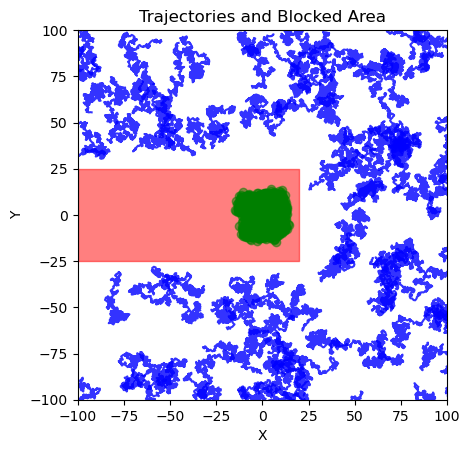

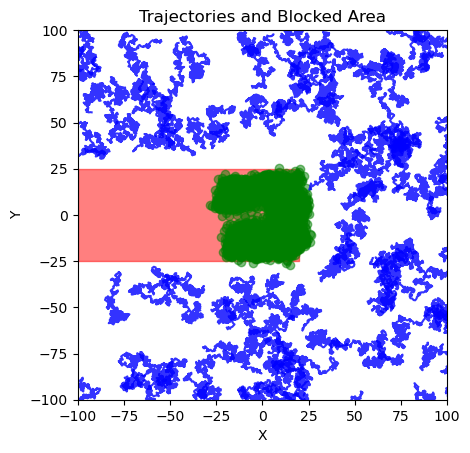

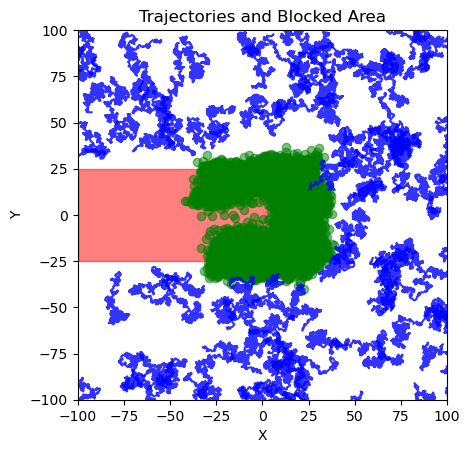

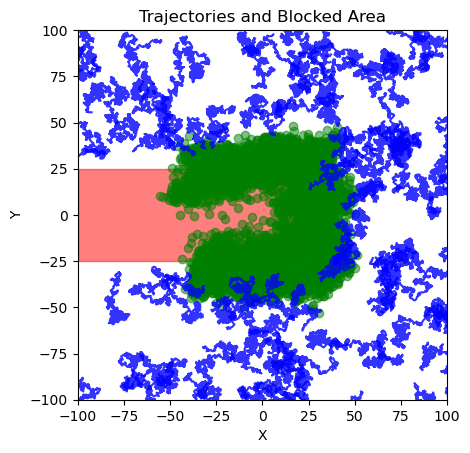

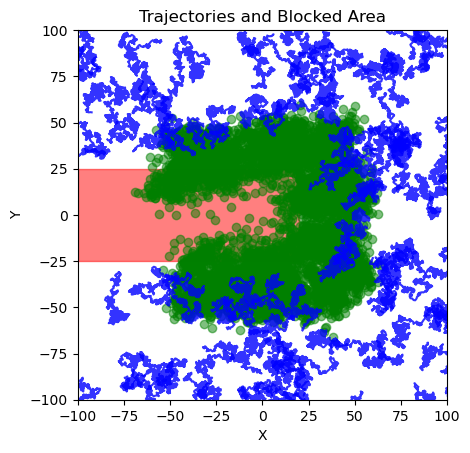

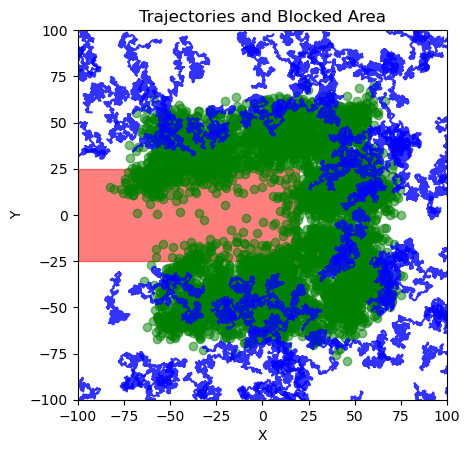

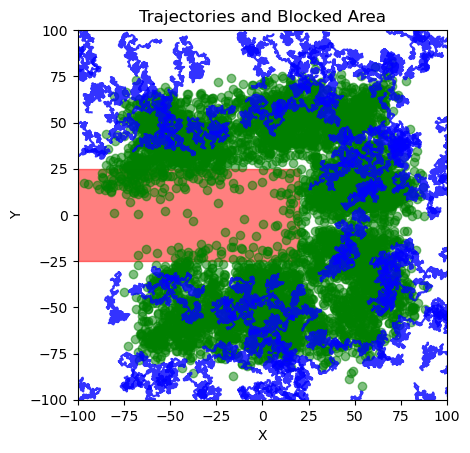

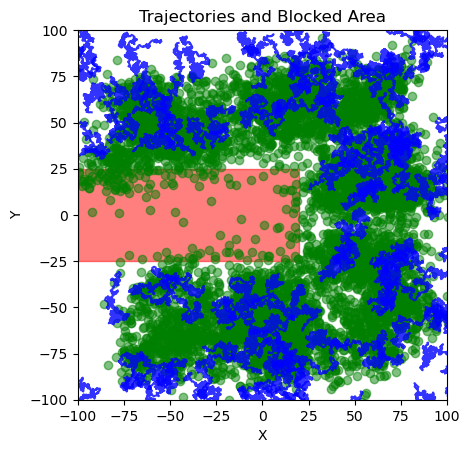

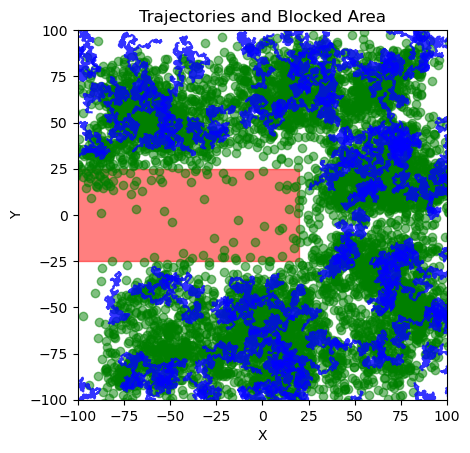

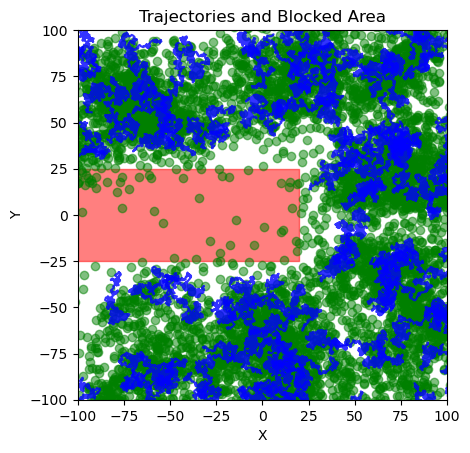

Done sampling


In [105]:
batch_size = 64
torch.manual_seed(42)
model.eval().requires_grad_(False)
# xt = torch.randn(batch_size, num_steps, 2, device=device) # Generates a point/trajectory for sampling defined by each step in trajectory (num_steps)
xt = torch.randn(batch_size, num_trajectories, 2, device=device) # Generates a point/trajectory that equals the amount of trajectories (more appropriate then num_steps)
steps = 1000
plot_every = 100
for i, t in enumerate(torch.linspace(0, 1, steps, device=device), start=1):
    t = t.view(1, 1, 1).expand(xt.size(0), xt.size(1), xt.size(2))
    pred = model(xt, t)
    pred = pred[:, :, 0, :]
    xt = xt + (1/steps) * pred
    if i % plot_every == 0:
        plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max])
        plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='red', alpha=0.5)
        for count, trajectory in enumerate(valid_trajectories):
            trajectory = np.array(trajectory)
            plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label=f"Trajectory {count}", alpha=0.8)
        # for traj in xt.detach().cpu().numpy(): # Trajectories
        #     plt.plot(traj[:, 0], traj[:, 1], color='green', alpha=0.3)  # alpha=0.5
        plt.scatter( # Points
            xt[:, :, 0].detach().cpu().numpy(), # detach from computation tracked by PyTorch autograd
            xt[:, :, 1].detach().cpu().numpy(), # Move from GPU memory to CPU memory so that it can be converted into NumPy array
            color='green', alpha=0.5
            )
        plt.title("Trajectories and Blocked Area")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        # Save the plots
        script_dir = os.getcwd()
        results_dir = os.path.join(script_dir, "Progression/")
        fig_name = f"FM_Progression{i}.png"
        os.makedirs(results_dir, exist_ok=True)
        plt.savefig(os.path.join(results_dir, fig_name))
        plt.show()
        
        plt.close()
        
model.train().requires_grad_(True)
print("Done sampling")